# Table of Contents

- [Initialize](#Initialize)
- [Cosmological Parameters](#Cosmological_parameters)
- [Standard class calculation](#standard_class)
- [Accelerated standard class calculation](#accelerated_standard_class_calculation)
    - [Compare Outputs](#compare_outputs)
- [Fast Planck+BAO+fs8 analysis with class-sz](#Fast_MCMC_analysis_with_class-sz)
    - [Evaluate Mode](#Evaluate_Mode)
    - [MCMC Mode](#MCMC_Mode)
- [Fast ACT MCMC analysis with class-sz](#Fast_ACT_analysis_with_class-sz)
- [Thermal SZ power spectrum](#cl_sz)
- [Galxy power spectra](#cl_gg)
- [Galxy-CMB lensing power spectra](#cl_gk)
- [Combo calculation](#combo)
- [Custom tracer](#custom)


Many more things in https://github.com/CLASS-SZ/notebooks !

$\texttt{class-sz}$ ([code](https://github.com/CLASS-SZ/class_sz), [paper](https://inspirehep.net/literature/2715411)) uses Lesgourgues' $\texttt{class}$ ([code](https://github.com/lesgourg/class_public), [paper](https://arxiv.org/abs/1104.2932)) and Spurio Mancini's $\texttt{cosmpower}$ ([code](https://github.com/alessiospuriomancini/cosmopower), [paper](https://arxiv.org/abs/2106.03846)).

This notebook further uses Torrado \& Lewis' $\texttt{Cobaya}$ ([code](https://github.com/CobayaSampler/cobaya), [paper](https://arxiv.org/abs/2005.05290)) and Lewis' $\texttt{GetDist}$ ([code](https://github.com/cmbant/getdist), [paper](https://arxiv.org/abs/1910.13970)).

# Intialize<a id="Initialize"></a>

Some useful imports for this notebook:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
import numpy as np
import os
import scipy
import yaml
import subprocess
root_path = os.path.abspath("")
path_to_chains_dir = root_path + '/mcmcs/cobaya/chains/'

print(root_path)
print(path_to_chains_dir)


from getdist import loadMCSamples, MCSamples
from getdist import plots

/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/


The main import for the class_sz code:

In [2]:
from classy_sz import Class

2023-12-05 10:42:10.787182: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 10:42:10.787201: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 10:42:10.787207: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 10:42:10.787240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 10:42:10.787253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Since $\texttt{class-sz}$ generaly returns $D_\ell = \ell(\ell+1)C_\ell/2\pi$, it is useful to define a function for the conversion:

In [3]:
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

# Cosmological Parameters<a id="Cosmological_parameters"></a>

Let us define a set of cosmological parameters:

- '**omega_b**' is the the reduced baryon fraction, $\Omega_b h^2$,
- '**omega_cdm**' is the reduced dark matter fraction, $\Omega_c h^2$
- '**H0**' is the Hubble constant in units of km/s/Mpc
- '**tau_reio**' is the optical depth
- '**ln10^{10}A_s**' sets the primordial scalar power spectrum amplitude, $A_s$, at pivot scale '**k_pivot**' (also an input parameter)
- '**n_s**' is the scalar spectral index

We also chose a specific neutrino setting. Here, we opt for one massive neutrinos and two masless states. In $\texttt{class}$/$\texttt{class_sz}$ this is set via the parameters **N_ncdm**, **N_ur** and **m_ncdm**. 

Thus we define the following dictionnary:

In [4]:
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, 
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
'k_pivot': 0.05, 
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06    
}



# Standard $\texttt{class}$ calculation<a id="standard_class"></a>

All of the $\texttt{class}$ quantities are available within $\texttt{class_sz}$ because ***$\texttt{class_sz}$ contains $\texttt{class}$***. 

Let us run a typical $\texttt{class}$ calculations. Namely, of the lensed Cosmic Microwave Background (CMB) power spectra in temperature and polarization, as well as the matter power spectrum until redshift $z=1$.

### only background and thermo:

In [5]:
%%time 
M = Class()
M.set(cosmo_params)
M.set({
'output':' ',
})
M.compute()

CPU times: user 46.7 ms, sys: 5.56 ms, total: 52.3 ms
Wall time: 56.9 ms


In [6]:
M.Neff()

3.045998221453422

In [7]:
M.rs_drag()

147.21764945997361

In [8]:
%%time 
M_slow = Class()
M_slow.set(cosmo_params)
M_slow.set({
'output':'tCl,lCl,pCl,mPk',
'lensing':'yes',
'l_max_scalars' : 4500,
'non_linear':'hmcode',
'z_max_pk': 15.,
})
M_slow.compute()

CPU times: user 15.8 s, sys: 333 ms, total: 16.1 s
Wall time: 5.44 s


We can collect the results as follows:

In [10]:
lensed_cls = M_slow.lensed_cl()
l = lensed_cls['ell']
cl_tt = lensed_cls['tt']
cl_ee = lensed_cls['ee']
cl_te = lensed_cls['te']
cl_pp = lensed_cls['pp']

We can also print other quantities, such as:

In [12]:
z_arr = np.array([0.38, 0.51, 0.61])
print(M_slow.effective_f_sigma8(z_arr[0]))
print(M_slow.Hubble(z_arr[0]))
print(M_slow.angular_distance(z_arr[0]))

0.47288046750288165
0.00027702103446960763
1107.5131391691448


# Accelerated standard $\texttt{class}$ calculation<a id="accelerated_standard_class"></a>


With $\texttt{class_sz}$ we can can run accelerated standard $\texttt{class}$ calculations, using the $\texttt{class_sz}$ wrapper around the $\texttt{cosmopower}$ emulators presented in [Bolliet et al 2023](https://inspirehep.net/literature/2638458). 

To do so, we use the same format as just above, but instead of the $\texttt{compute}()$ method we call $\texttt{compute_class_szfast}()$ method:

In [64]:
%%time 
M = Class()
M.set(cosmo_params)
M.set({
'output':'tCl,lCl,pCl',
'skip_background_and_thermo': 0,
'skip_pkl': 1,
'skip_pknl': 1,
'skip_sigma8_and_der': 1,
'skip_sigma8_at_z': 1,
'skip_chi': 1,
'skip_hubble': 1,
'cosmo_model' : 0, # cosmo_model : 0 for lcdm, 1 for mnu (with one massive/two massless states), 2 for Neff, and 3 for wcdm
})
M.compute_class_szfast()

CPU times: user 65.9 ms, sys: 16.1 ms, total: 82.1 ms
Wall time: 66.6 ms


Time it:

In [65]:
M = Class()
def compute_class_sz(M):
    M.set(cosmo_params)
    M.set({
    'output':'tCl,lCl,pCl',
    'skip_background_and_thermo': 1,
    'skip_pkl': 1,
    'skip_pknl': 1,
    'skip_sigma8_and_der': 1,
    'skip_sigma8_at_z': 1,
    'skip_chi': 1,
    'skip_hubble': 1,
    'cosmo_model' : 1,
    })
    M.compute_class_szfast()

In [66]:
%timeit -n 10 compute_class_sz(M)

22.7 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This calculation is 100's times faster than the standard $\texttt{class}$ calculation. 

Nonetheless, in the above, we have not computed the matter power spectrum. To access the matter power spectrum we set the "skip" switches to 0:

In [68]:
%%time 
M = Class()
M.set(cosmo_params)
M.set({
'output':'tCl,lCl,pCl,mPk',
'skip_background_and_thermo': 1,
'skip_pkl': 0,
'skip_pknl': 0,
'skip_sigma8_and_der': 1,
'skip_sigma8_at_z': 1,
'skip_chi': 1,
'skip_hubble': 1,
'ndim_redshifts': 10 ## this controls how many redshift points we use
})
M.compute_class_szfast()

CPU times: user 79 ms, sys: 34.9 ms, total: 114 ms
Wall time: 66.8 ms


In [69]:
%timeit -n 10 M.compute_class_szfast()

43.9 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As you can see, we have also added the parameter **ndim_redshifts**. This sets the number of redhsifts points ( between $z_\mathrm{min}=0$ and $z_\mathrm{max}=5$) where the matter power spectra are evaluated. Note that you can set $z_\mathrm{max}$ to any value you want (e.g., higher than 5), the emulated power spectra will be extraploted automatically with the linear approximation, which is excellent at these high-redshifts.  


Setting this parameter to higher values increases the precision but also the calculation time. Try it yourself !


Since $\texttt{class-sz}$ contains $\texttt{class}$ we can request **exact** background cosmology calculation, while still requesting the emulated $P(k)$ and $C_{\ell}$'s. To do so we set:

'skip_background_and_thermo': 0

As follows:

In [70]:
%%time 


M_fast = Class()
M_fast.set(cosmo_params)
M_fast.set({
'output':'tCl,lCl,pCl,mPk',
'skip_background_and_thermo': 0,
'skip_pkl': 0,
'skip_pknl': 0,
'skip_sigma8_and_der': 0,
'skip_sigma8_at_z': 0,
'skip_chi': 1,
'skip_hubble': 1,
'ndim_redshifts': 50,
'cosmo_model' : 0,

})
M_fast.compute_class_szfast()

CPU times: user 213 ms, sys: 81.7 ms, total: 295 ms
Wall time: 185 ms


In [71]:
%timeit -n 10 M_fast.compute_class_szfast()

135 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
lensed_cls = M_fast.lensed_cl()
l_fast = lensed_cls['ell']
cl_tt_fast = lensed_cls['tt']

In [73]:
cl_tt_fast[1000:10010]

array([8.97031335e-16, 8.93388903e-16, 8.89915694e-16, ...,
       1.51571158e-21, 1.51480942e-21, 1.51386600e-21])

We can now print similar quantities as the standard $\texttt{class}$ calculation:

In [86]:
zp = 10
print(M_fast.effective_f_sigma8(zp))
print(M_fast.Hubble(zp))
print(M_fast.angular_distance(zp))
print(M_fast.sigma8())
print(M_fast.Neff())

0.09382873835345938
0.004602416470047569
876.0528171847849
0.8100192319093221
3.045998221453422


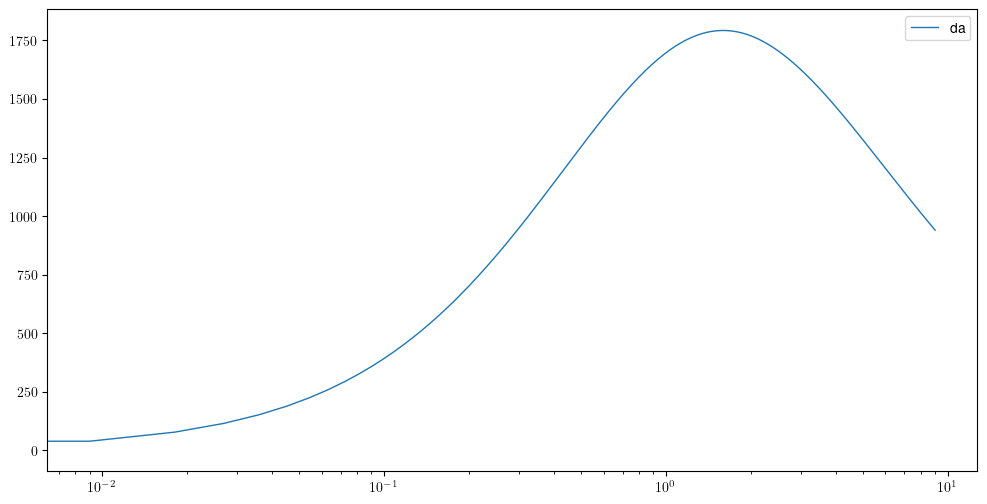

In [77]:
zt = np.linspace(0.,9.,1000)

xarr = zt
yarr = np.vectorize(M_fast.Hubble)(zt)
dyarr = np.gradient(yarr,xarr)
yarr = np.vectorize(M_fast.angular_distance)(zt)
dyarr = np.gradient(yarr,xarr)
fig = plt.figure(figsize=(12,6))
plt.plot(xarr,yarr,label='da',lw=1)
plt.xscale('log')
plt.legend()


And collect the spectra:

In [78]:
lensed_cls = M_fast.lensed_cl()
l_fast = lensed_cls['ell']
cl_tt_fast = lensed_cls['tt']
cl_ee_fast = lensed_cls['ee']
cl_te_fast = lensed_cls['te']
cl_pp_fast = lensed_cls['pp']

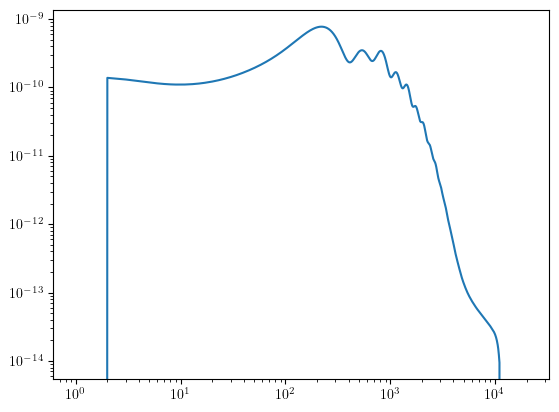

In [79]:
plt.plot(l_fast,l_to_dl(l_fast)*cl_tt_fast)
plt.loglog()
plt.show()

## Compare outputs<a id="compare_outputs"></a>

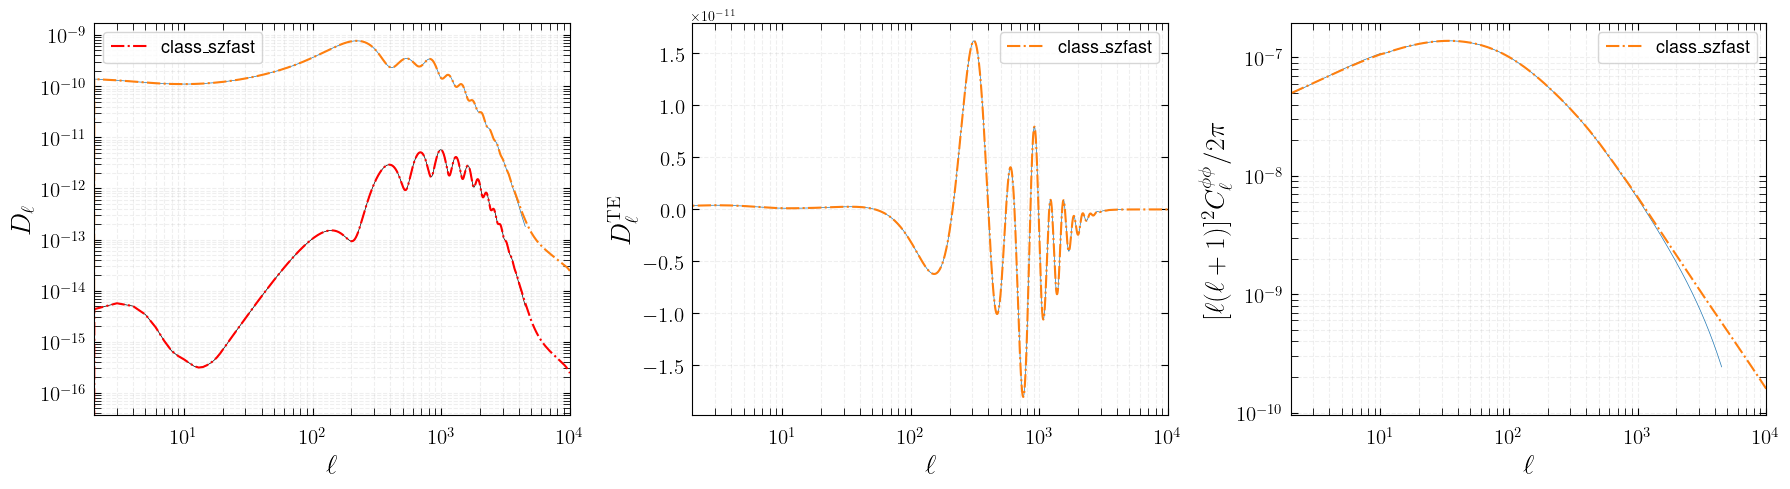

In [80]:
label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


ax.plot(l,l_to_dl(l)*cl_tt,lw=0.5)
ax.plot(l_fast,l_to_dl(l_fast)*cl_tt_fast,ls='-.')


ax.plot(l,l_to_dl(l)*cl_ee,lw=0.5,c='k')
ax.plot(l_fast,l_to_dl(l_fast)*cl_ee_fast,ls='-.',c='red',label='class_szfast')



ax.set_ylabel(r"$D_\ell$",size=title_size)
ax.set_xlabel(r"$\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(2e0,1e4)
ax.set_xlim(2,1e4)
ax.legend(fontsize=legend_size)


ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


ax.plot(l,l_to_dl(l)*cl_te,lw=0.5)
ax.plot(l_fast,l_to_dl(l_fast)*cl_te_fast,ls='-.',label='class_szfast')


ax.set_ylabel(r"$D_\ell^\mathrm{TE}$",size=title_size)
ax.set_xlabel(r"$\ell$",size=title_size)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(2e0,1e4)
ax.set_xlim(2,1e4)
ax.legend(fontsize=legend_size)


ax = ax3
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')

ax.plot(l,l_to_dl(l)*cl_pp*(l*(l+1.)),lw=0.5)
ax.plot(l_fast,l_to_dl(l_fast)*cl_pp_fast*(l_fast*(l_fast+1.)),ls='-.',label='class_szfast')

ax.set_ylabel(r"$[\ell(\ell+1)]^2 C_\ell^{\phi\phi}/2\pi$",size=title_size)
ax.set_xlabel(r"$\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2,1e4)
ax.legend(fontsize=legend_size)
fig.tight_layout()

At high-$\ell$ the standard class calculation is inaccurate! However the one produced by our cosmopower emulators are well accurate!

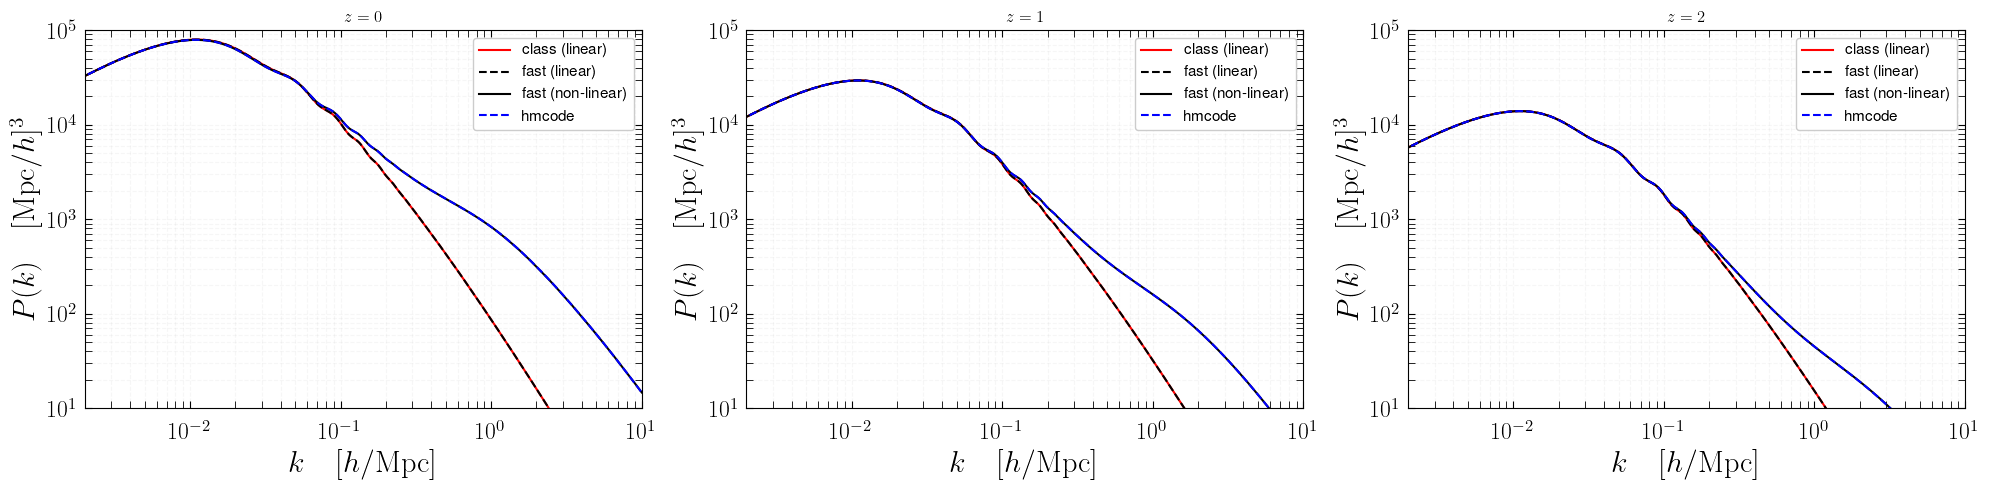

In [81]:
k1_a = np.geomspace(1e-3,10.,500)
h = M_fast.h()

label_size = 17
title_size = 22
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.1, linestyle='--')

ax.set_ylabel(r'$P(k)\quad\mathrm{[Mpc}/h]^3$',size=title_size)
ax.set_xlabel(r'$k\quad[h\mathrm{/Mpc]}$',size=title_size)

z = 0.
pk1_lin = np.vectorize(M_slow.pk_lin)(k1_a,z)
pk1_lin_fast = np.vectorize(M_fast.pk_lin)(k1_a,z)
pk1_nonlin_fast = np.vectorize(M_fast.pk)(k1_a,z)
pk1_nonlin_hmcode = np.vectorize(M_slow.pk)(k1_a,z)


ax.plot(k1_a,pk1_lin,label=r'class (linear)',alpha=1.,c='r')
ax.plot(k1_a,pk1_lin_fast,label=r'fast (linear)',alpha=1.,c='k',ls='--')
ax.plot(k1_a,pk1_nonlin_fast,label=r'fast (non-linear)',alpha=1.,c='k')
ax.plot(k1_a,pk1_nonlin_hmcode,label=r'hmcode',alpha=1.,c='b',ls='--')
ax.loglog()

ax.set_ylim(1e1,1e5)
ax.set_xlim(2e-3,1e1)

ax.legend(loc=1,frameon=True,framealpha=1,fontsize=11)

ax.set_title(r'$z=0$')

ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.1, linestyle='--')

ax.set_ylabel(r'$P(k)\quad\mathrm{[Mpc}/h]^3$',size=title_size)
ax.set_xlabel(r'$k\quad[h\mathrm{/Mpc]}$',size=title_size)

z = 1.
pk1_lin = np.vectorize(M_slow.pk_lin)(k1_a,z)
pk1_lin_fast = np.vectorize(M_fast.pk_lin)(k1_a,z)
pk1_nonlin_fast = np.vectorize(M_fast.pk)(k1_a,z)
pk1_nonlin_hmcode = np.vectorize(M_slow.pk)(k1_a,z)


ax.plot(k1_a,pk1_lin,label=r'class (linear)',alpha=1.,c='r')
ax.plot(k1_a,pk1_lin_fast,label=r'fast (linear)',alpha=1.,c='k',ls='--')
ax.plot(k1_a,pk1_nonlin_fast,label=r'fast (non-linear)',alpha=1.,c='k')
ax.plot(k1_a,pk1_nonlin_hmcode,label=r'hmcode',alpha=1.,c='b',ls='--')
ax.loglog()

ax.set_ylim(1e1,1e5)
ax.set_xlim(2e-3,1e1)

ax.legend(loc=1,frameon=True,framealpha=1,fontsize=11)

ax.set_title(r'$z=1$')

ax = ax3
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.1, linestyle='--')

ax.set_ylabel(r'$P(k)\quad\mathrm{[Mpc}/h]^3$',size=title_size)
ax.set_xlabel(r'$k\quad[h\mathrm{/Mpc]}$',size=title_size)

z = 2.
pk1_lin = np.vectorize(M_slow.pk_lin)(k1_a,z)
pk1_lin_fast = np.vectorize(M_fast.pk_lin)(k1_a,z)
pk1_nonlin_fast = np.vectorize(M_fast.pk)(k1_a,z)
pk1_nonlin_hmcode = np.vectorize(M_slow.pk)(k1_a,z)


ax.plot(k1_a,pk1_lin,label=r'class (linear)',alpha=1.,c='r')
ax.plot(k1_a,pk1_lin_fast,label=r'fast (linear)',alpha=1.,c='k',ls='--')
ax.plot(k1_a,pk1_nonlin_fast,label=r'fast (non-linear)',alpha=1.,c='k')
ax.plot(k1_a,pk1_nonlin_hmcode,label=r'hmcode',alpha=1.,c='b',ls='--')
ax.loglog()

ax.set_ylim(1e1,1e5)
ax.set_xlim(2e-3,1e1)

ax.legend(loc=1,frameon=True,framealpha=1,fontsize=11)

ax.set_title(r'$z=2$')




fig.tight_layout()

We can also compute $P(k)$ beyond where the range of emulators, using the linear regime approximation $\delta(a)=D(a)\delta(1)$ which is totally fine at $z>5$. 

Text(0.5, 1.0, '$z=10$')

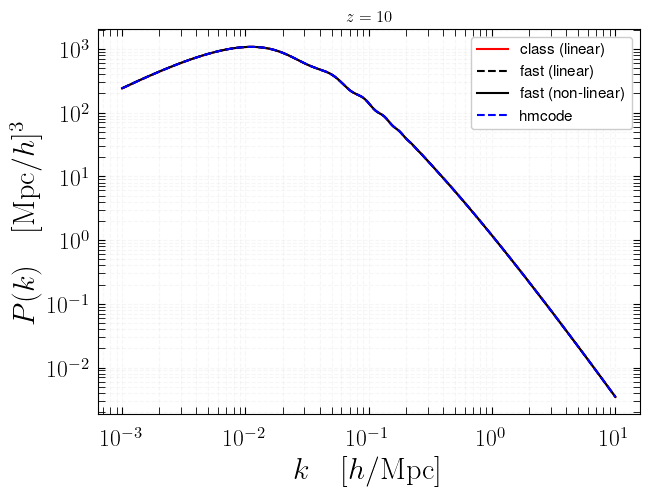

In [82]:
label_size = 17
title_size = 22
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(7,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.1, linestyle='--')

ax.set_ylabel(r'$P(k)\quad\mathrm{[Mpc}/h]^3$',size=title_size)
ax.set_xlabel(r'$k\quad[h\mathrm{/Mpc]}$',size=title_size)

z = 10.
pk1_lin = np.vectorize(M_slow.pk_lin)(k1_a,z)
pk1_lin_fast = np.vectorize(M_fast.pk_lin)(k1_a,z)
pk1_nonlin_fast = np.vectorize(M_fast.pk)(k1_a,z)
pk1_nonlin_hmcode = np.vectorize(M_slow.pk)(k1_a,z)


ax.plot(k1_a,pk1_lin,label=r'class (linear)',alpha=1.,c='r')
ax.plot(k1_a,pk1_lin_fast,label=r'fast (linear)',alpha=1.,c='k',ls='--')
ax.plot(k1_a,pk1_nonlin_fast,label=r'fast (non-linear)',alpha=1.,c='k')
ax.plot(k1_a,pk1_nonlin_hmcode,label=r'hmcode',alpha=1.,c='b',ls='--')
ax.loglog()

# ax.set_ylim(1e1,1e5)
# ax.set_xlim(2e-3,1e1)

ax.legend(loc=1,frameon=True,framealpha=1,fontsize=11)

ax.set_title(r'$z=10$')

# Fast Planck+BAO MCMC analysis with $\texttt{class-sz}$<a id = 'Fast_MCMC_analysis_with_class-sz'></a>

With this machinery, we can run fast MCMC analysis. For example, let us run a joint $\textit{Planck}$ CMB lensing and SDSS BAO analysis. 

To do so, we load a template cobaya input file, which we adapt to our needs:

In [91]:
Dict_yaml = yaml.safe_load(open(root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8-classy_sz.yaml'))
path_to_cobaya_packages_data = root_path+'/../../cobaya_packages/data'

Dict_yaml['sampler'].pop('mcmc')
Dict_yaml['sampler']['evaluate'] = {}

Dict_yaml['likelihood']['planck_2018_lensing.CMBMarged']['path'] = path_to_cobaya_packages_data + '/planck_supp_data_and_covmats'
Dict_yaml['likelihood']['bao.sdss_dr12_consensus_full_shape']['path'] = path_to_cobaya_packages_data 


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1

Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['lensing_lkl'] = 'Planck'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl,lCl,pCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need pk's
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need pk's
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['ndim_redshifts'] = 20


Dict_yaml['output'] = path_to_chains_dir +'planck_lensing_and_sdssfs8'

We can add many derived parameters (as many as $\texttt{class}$ knows):

In [92]:
Dict_yaml['params']['omegam'] = {}
Dict_yaml['params']['omegam']['latex'] = '\Omega_\mathrm{m}'
Dict_yaml['params']['omegam']['derived'] = True

Dict_yaml['params']['omegamh2'] = {}
Dict_yaml['params']['omegamh2']['derived'] = 'lambda omegam, H0: omegam*(H0/100)**2'
Dict_yaml['params']['omegamh2']['latex'] = '\Omega_\mathrm{m} h^2'

Dict_yaml['params']['rdrag'] = {}
Dict_yaml['params']['rdrag']['latex'] = 'r_\mathrm{drag}'
Dict_yaml['params']['rdrag']['derived'] = True

Dict_yaml['params']['zrei'] = {}
Dict_yaml['params']['zrei']['latex'] = 'z_\mathrm{re}'
Dict_yaml['params']['zrei']['derived'] = True

Dict_yaml['params']['s8h5'] = {}
Dict_yaml['params']['s8h5']['latex'] = '\sigma_8/h^{0.5}'
Dict_yaml['params']['s8h5']['derived'] = 'lambda sigma8, H0: sigma8*(H0*1e-2)**(-0.5)'

Dict_yaml['params']['s8omegamp25'] = {}
Dict_yaml['params']['s8omegamp25']['latex'] = '\sigma_8 \Omega_\mathrm{m}^{0.25}'
Dict_yaml['params']['s8omegamp25']['derived'] = 'lambda sigma8, omegam: sigma8*omegam**0.25'


Dict_yaml['params']['s8omegamp5'] = {}
Dict_yaml['params']['s8omegamp5']['latex'] = '\sigma_8 \Omega_\mathrm{m}^{0.5}'
Dict_yaml['params']['s8omegamp5']['derived'] = 'lambda sigma8, omegam: sigma8*omegam**0.5'

Dict_yaml['params']['S825'] = {}
Dict_yaml['params']['S825']['latex'] = '\sigma_8 (\Omega_\mathrm{m}/0.3)^{0.25}'
Dict_yaml['params']['S825']['derived'] = 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.25'


Dict_yaml['params']['S85'] = {}
Dict_yaml['params']['S85']['latex'] = '\sigma_8 (\Omega_\mathrm{m}/0.3)^{0.5}'
Dict_yaml['params']['S85']['derived'] = 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.5'

Dict_yaml['params']['sigma8'] = {}
Dict_yaml['params']['sigma8']['latex'] = '\sigma_8'
Dict_yaml['params']['sigma8']['derived'] = True


Dict_yaml['params']['YHe'] = {}
Dict_yaml['params']['YHe']['latex'] = 'Y_\mathrm{He}'
Dict_yaml['params']['YHe']['derived'] = True


Dict_yaml['params']['Neff'] = {}
Dict_yaml['params']['Neff']['latex'] = 'N_\mathrm{eff}'
Dict_yaml['params']['Neff']['derived'] = True


Dict_yaml['timing'] = True 

with open(root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

## Evaluate Mode<a id='Evaluate_Mode'></a>

In [93]:
%%time
str_cmd_subprocess = ["cobaya-run",
                      root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains', with prefix 'planck_lensing_and_sdssfs8'
[output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8'
[output] Will delete previous products ('force' was requested).
[absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


2023-12-05 11:25:38.977021: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:25:38.977119: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:25:38.977130: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:25:38.977167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 11:25:38.977194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[prior] *WARNING* External prior 'ns_prior' loaded. Mind that it might not be normalized!
[prior] *WARNING* External prior 'omb_prior' loaded. Mind that it might not be normalized!
[classy_szfast.classy_sz.classy_sz] Initialized!
[bao.sdss_dr12_consensus_full_shape] Initialized.
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   H0 = 66.1791
   logA = 3.20236
   n_s = 0.982056
   omega_b = 0.0220229
   omega_cdm = 0.105245
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = 6.33734
[evaluate] log-prior      = 13.9468
[evaluate]    logprior_0 = 4.94251
[evaluate]    logprior_ns_prior = 2.38499
[evaluate]    logprior_omb_prior = 6.61925
[evaluate] log-likelihood = -7.60942
[evaluate]   

0

In these settings, $\texttt{class_sz}$ took $\approx$70ms to compute. Let us know switch to mcmc mode.

## MCM Mode<a id='MCMC_Mode'></a>

In [94]:
Dict_yaml = yaml.safe_load(open(root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8_system.yaml'))
Dict_yaml['sampler'].pop('evaluate')
Dict_yaml['sampler']['mcmc'] = {
    'covmat': path_to_chains_dir + '../covmats/planck_lensing_and_sdssfs8.covmat',
    'Rminus1_stop': 0.1,
    'burn_in': 100,
    'drag': False,
    'proposal_scale': 0.8,
    'learn_proposal': True,
    'learn_every': 200,
    'learn_proposal_Rminus1_max': 100.,
    'max_tries' : 100000,
    'learn_proposal_Rminus1_max_early': 100.,
}
with open(root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8_system_mcmc.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

Once, we have updated the yaml file, we aready to run the chains:

In [95]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      root_path+'/mcmcs/cobaya/input_files/planck_lensing_and_sdssfs8_system_mcmc.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains', with prefix 'planck_lensing_and_sdssfs8'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8'
[0 : output] Will delete previous products ('force' was requested).
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[1 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instea

2023-12-05 11:25:59.046048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:25:59.046094: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:25:59.046105: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:25:59.046104: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:25:59.046140: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:25:59.046048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:25:59.046092: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:25:59.046101: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:25:59.046142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. You

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : prior] *WARNING* External prior 'ns_prior' loaded. Mind that it might not be normalized!
[0 : prior] *WARNI

0

### Analyse the chains

In [96]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'planck_lensing_and_sdssfs8')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
p = readsamps.getParams()
print('adding derived parameters')
p = readsamps.getParams()
readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
Fs = readsamps.getInlineLatex('Ombc',limit=1)
print('Ombc: ',Fs)

samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8
producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/planck_lensing_and_sdssfs8.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.03534
RL: Thin for Markov:  8
RL: Thin for indep samples:   11
RL: Estimated burn in steps:  296  ( 194  rows)
using 5877 rows, 24 parameters; mean weight 1.5228858261017526, tot weight 8950.0
Approx indep samples (N/corr length): 247
Equ

producing files in directory  ./
Removed 0.2 as burn in
using 5877 rows, 24 parameters; mean weight 1.5228858261017526, tot weight 8950.0
Approx indep samples (N/corr length): 247
Equiv number of single samples (sum w)/max(w): 1119
Effective number of weighted samples (sum w)^2/sum(w^2): 4366
Best fit sample -log(Like) = -7.088164
Ln(mean 1/like) = -2.538849
mean(-Ln(like)) = -4.598403
-Ln(mean like)  = -5.373024


## Plot the posterior

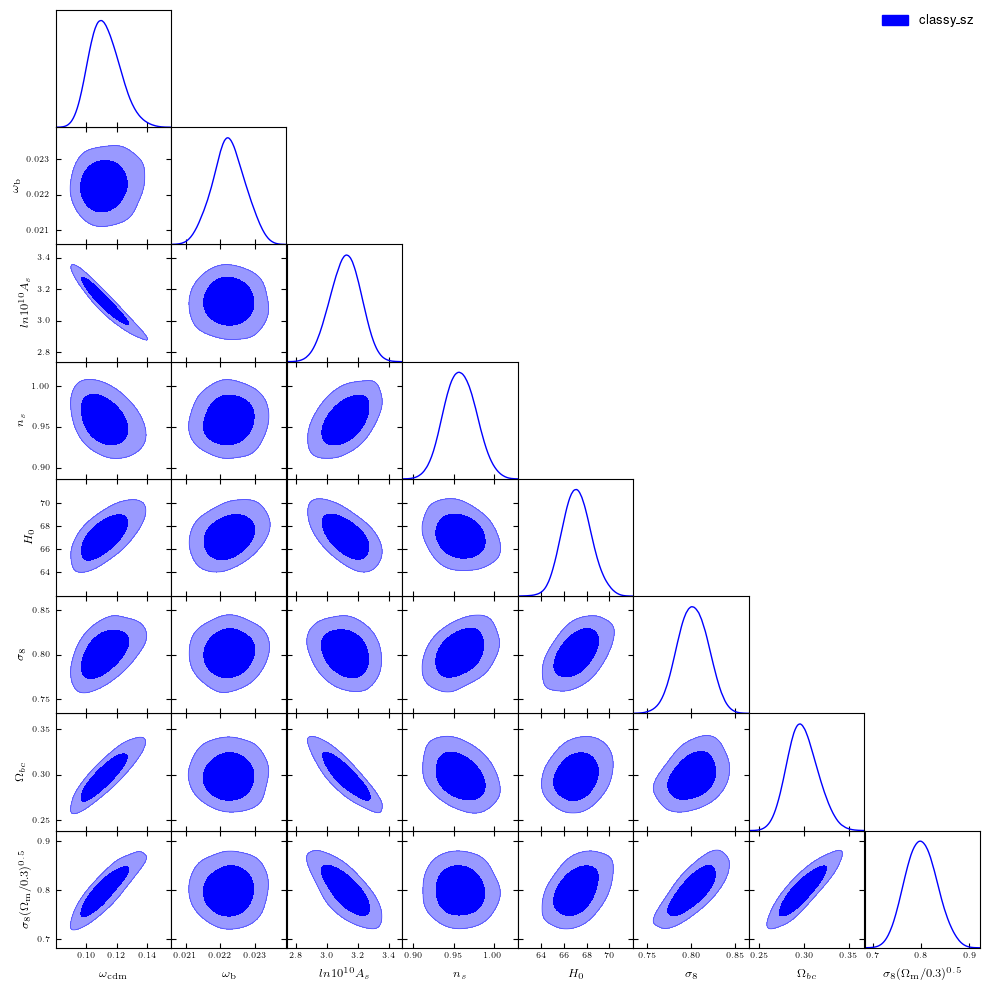

In [97]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    'omega_cdm',
    'omega_b',
    'logA',
    'n_s',
    'H0',
    'sigma8',
    'Ombc',
    'S85',
    ],

    filled=[True,False],
    legend_labels=[ 'classy_sz'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )


# g.export(path_to_chains_dir +'planck_lensing_and_sdssfs8_contours_classy_sz.pdf')

# Fast ACT MCMC analysis with $\texttt{class-sz}$<a id = 'Fast_ACT_analysis_with_class-sz'></a>

In [98]:
Dict_yaml = yaml.safe_load(open(root_path+'/mcmcs/cobaya/input_files/pyactlike.yaml'))
print(Dict_yaml)

{'output': 'plikHMTTTEE', 'likelihood': {'pyactlike.ACTPol_lite_DR4': {'stop_at_error': True}}, 'theory': None, 'params': {'omega_b': {'prior': {'min': 0.01933, 'max': 0.02533}, 'ref': {'dist': 'norm', 'loc': 0.022211104, 'scale': 0.00088253849}, 'proposal': 0.00088253849, 'latex': '\\omega_\\mathrm{b}'}, 'omega_cdm': {'prior': {'min': 0.08, 'max': 0.2}, 'ref': {'dist': 'norm', 'loc': 0.12590565, 'scale': 0.012255042}, 'proposal': 0.012255042, 'latex': '\\omega_\\mathrm{cdm}'}, 'H0': {'prior': {'min': 40.0, 'max': 99.0}, 'ref': {'dist': 'norm', 'loc': 69.351243, 'scale': 2.0}, 'proposal': 2.0, 'latex': 'H_0'}, 'n_s': {'prior': {'min': 0.8812, 'max': 1.0492}, 'ref': {'dist': 'norm', 'loc': 0.95989286, 'scale': 0.019465327}, 'proposal': 0.019465327, 'latex': 'n_s'}, 'logA': {'prior': {'min': 2.5, 'max': 3.5}, 'ref': {'dist': 'norm', 'loc': 2.9939341, 'scale': 0.12892144}, 'proposal': 0.12892144, 'latex': 'ln10^{10}A_s'}, 'tau_reio': {'prior': {'dist': 'norm', 'loc': 0.065, 'scale': 0.015

In [99]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir + '../covmats/pyactlike.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.05


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this



with open(root_path+'/mcmcs/cobaya/input_files/pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

In [100]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      root_path+'/mcmcs/cobaya/input_files/pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains', with prefix 'pyactlike'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike'
[0 : output] Will delete previous products ('force' was requested).
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[1 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[3 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers

2023-12-05 11:42:53.681529: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:42:53.681572: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:42:53.681585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:42:53.681518: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:42:53.681562: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:42:53.681574: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:42:53.681520: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-05 11:42:53.681560: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 11:42:53.681571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 11:42:53.681535: I metal_plugin/src/device/metal_device.cc:1154] Metal dev

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : classy_szfast.classy_sz.classy_sz] Initialized!
[0 : classy_szfast.classy_sz.classy_sz] Initialized!
[1 : c

0

In [101]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.1})
p = readsamps.getParams()

samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike
producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/mcmcs/cobaya/chains/pyactlike.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.03466
RL: Thin for Markov:  18
RL: Thin for indep samples:   30
RL: Estimated burn in steps:  180  ( 76  rows)
using 9297 rows, 11 parameters; mean weight 2.3662471765085513, tot weight 21999.0
Approx indep samples (N/corr length): 626
Equiv number of single samples (sum w)/max(w): 1222
Effective number of weighted sample

producing files in directory  ./
Removed 0.2 as burn in
using 9297 rows, 11 parameters; mean weight 2.3662471765085513, tot weight 21999.0
Approx indep samples (N/corr length): 626
Equiv number of single samples (sum w)/max(w): 1222
Effective number of weighted samples (sum w)^2/sum(w^2): 5921
Best fit sample -log(Like) = 131.680340
Ln(mean 1/like) = 137.830081
mean(-Ln(like)) = 134.895974
-Ln(mean like)  = 133.904903


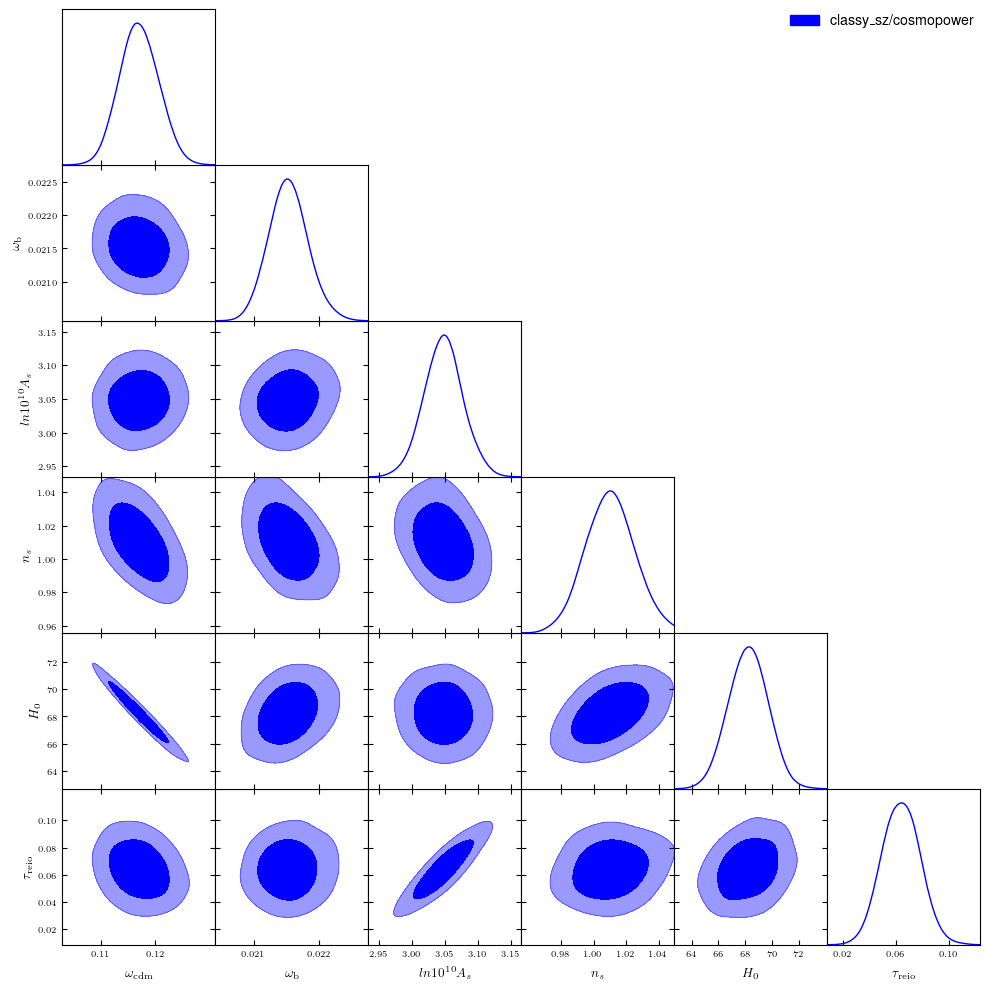

In [102]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    'omega_cdm',
    'omega_b',
    'logA',
    'n_s',
    'H0',
    'tau_reio',
    ],
    # param_limits={'n_s':(0.97, 1.1)},
    filled=[True,False],
    legend_labels=[ 'classy_sz/cosmopower'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )


g.export(path_to_chains_dir +'pyactlike_classy_sz_cosmopower.pdf')

# Thermal Sunyaev Zeldovich Power Spectrum Calculation<a id = 'cl_sz'></a>

In [103]:
%%time

M = Class()
M.set(cosmo_params)
M.set({

'output': 'tSZ_1h,tSZ_2h,dydz',
    
'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
 

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',

'hm_consistency' : 1,
'x_outSZ': 4.,
# 'truncate_gas_pressure_wrt_rvir':0,

'pressure profile':'Custom. GNFW',
    
"P0GNFW": 8.130,
"c500": 1.156,
"gammaGNFW": 0.3292,
"alphaGNFW": 1.0620,
"betaGNFW":5.4807,

"ell_min" : 2,
"ell_max" : 8000,
'dell': 0,
'dlogell': 0.2,
    
'M_min' : 1.0e10, 
'M_max' : 5e14,
    
'z_min' : 0.5,
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster


    
    
'hm_consistency' : 1,
    

'use_fft_for_profiles_transform' : 0,

'N_samp_fftw' : 512,
'x_min_gas_pressure_fftw' : 1e-4,
'x_max_gas_pressure_fftw' : 1e3,
    
    
# 'ndim_masses' : 500, # now muted/set by k's in cosmopower emulator.
'ndim_redshifts' :50,

    
'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0001,    

    
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0001,
    
# # testing with 3 massive neutrinos
# 'N_ncdm': 3,
# 'N_ur': 0.00641,
# 'm_ncdm': '0.06,0.06,0.06', 
})
M.compute_class_szfast()
# M.compute()

CPU times: user 395 ms, sys: 171 ms, total: 565 ms
Wall time: 554 ms


In [104]:
l = np.asarray(M.cl_sz()['ell'])
cl_yy_1h = np.asarray(M.cl_sz()['1h'])
cl_yy_2h = np.asarray(M.cl_sz()['2h'])

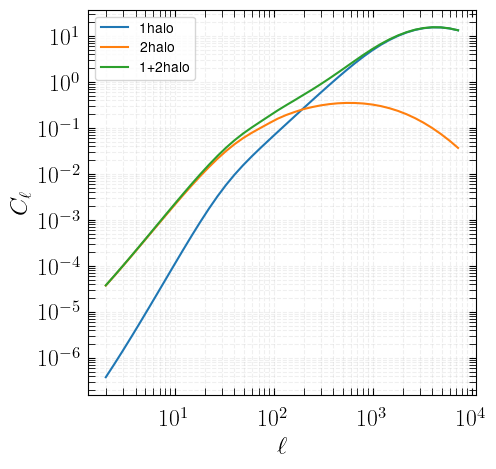

In [105]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"$\ell$ ",size=title_size)
ax.set_ylabel(r"$C_\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-1,1e4)
# ax.set_xlim(5e-2,1e1)
ax.plot(l,cl_yy_1h,label='1halo')
ax.plot(l,cl_yy_2h,label='2halo')
ax.plot(l,cl_yy_2h+cl_yy_1h,label='1+2halo')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend()

In [106]:
%%time
dydz=np.vectorize(M.get_dydz_at_z)
dydzdlnm = np.vectorize(M.get_dydzdlnm_at_z_and_m)
z_array_2d = np.linspace(0.01,2.5,500)
log10m_array = np.linspace(np.log10(1e12),np.log10(1e16),500)
dydzdm_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lm in log10m_array:
        dydzdm_2d[izp][ilq] = dydzdlnm(zp,10**lm,l=500)
        ilq+=1
    izp+=1

CPU times: user 2.45 s, sys: 2.87 ms, total: 2.45 s
Wall time: 2.46 s


Text(0.5, 1.0, '$\\ell = 500$')

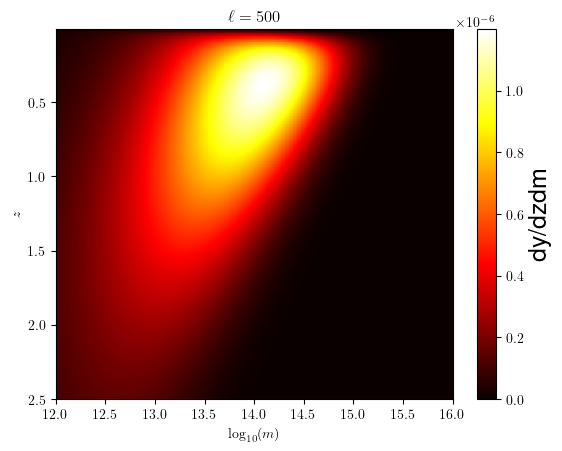

In [107]:
im = plt.imshow(dydzdm_2d, cmap='hot', interpolation='nearest',
                extent = [12,16,z_array_2d[-1],z_array_2d[0]],
                aspect='auto')
cbar = plt.colorbar(im) # adding the colobar on the right
cbar.set_label('dy/dzdm',size=18)
plt.xlabel('$\mathrm{log}_{10}(m)$')
plt.ylabel('$z$')
# plt.show()
plt.title('$\ell = 500$')
# plt.savefig('figures/dy500dzdlnm_heatmap.pdf')

# Halo model galaxy power spectra<a id = 'cl_gg'></a>

In [108]:
%%time
M = Class()
M.set(cosmo_params)
M.set({
'output' : 'galn_galn_1h,galn_galn_2h',
'galaxy_samples_list_num' : 3, # the number of galaxy samples
'galaxy_samples_list' : '1,2,4', # the id string of each sample, can be any integer
'full_path_and_prefix_to_dndz_ngal':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/class_sz_auxiliary_files/WISC_bin3_ngal_example'
})
M.set({# class_sz parameters:

'mass function': 'T08M200c',
'concentration parameter' : 'D08',
'hm_consistency': 1,

'delta for galaxies' : '200c',

# HOD parameters
'sigma_log10M_HOD_ngal_0' : 0.69,
'alpha_s_HOD_ngal_0' :  1.30,
'M1_prime_HOD_ngal_0' : 5.03e12, # Msun/h
'M_min_HOD_ngal_0' : 6.25e11, # Msun/h
'M0_HOD_ngal_0' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_0' : 1.09,    
'f_cen_HOD_ngal_0' : 1.,   
    
'sigma_log10M_HOD_ngal_1' : 0.79,
'alpha_s_HOD_ngal_1' :  1.30,
'M1_prime_HOD_ngal_1' : 5.43e12, # Msun/h
'M_min_HOD_ngal_1' : 6.15e11, # Msun/h
'M0_HOD_ngal_1' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_1' : 1.19,  
'f_cen_HOD_ngal_1' : 1.,    
    
'sigma_log10M_HOD_ngal_2' : 0.49,
'alpha_s_HOD_ngal_2' :  1.70,
'M1_prime_HOD_ngal_2' : 6.03e12, # Msun/h
'M_min_HOD_ngal_2' : 7.25e11, # Msun/h
'M0_HOD_ngal_2' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_2' : 0.89,  
'f_cen_HOD_ngal_2' : 1.,

'M0 equal M_min (HOD)'  : 'no',



'M_min' : 1e11,
'M_max' : 5e15,
'ndim_masses' : 100,
    
    
'z_min' : 0.,
'z_max' : 3.,
'ndim_redshifts' : 100,
    
    
'dlogell' : 0.3,
'ell_max' : 3000.0,
'ell_min' : 2.0,


    
# precisions params:
'non_linear' : 'halofit',
'k_min_for_pk_class_sz' :  0.001,
'k_max_for_pk_class_sz' :  60.0,
'k_per_decade_class_sz' :  50,
'P_k_max_h/Mpc' :  50.0,

    
'redshift_epsabs' : 1e-40,
'redshift_epsrel' : 0.0001,
'mass_epsabs' : 1e-40,
'mass_epsrel' : 0.0001    
    
        })
        
M.compute_class_szfast()
cl_galn_galn = M.cl_galn_galn()

CPU times: user 11 s, sys: 184 ms, total: 11.2 s
Wall time: 1.65 s


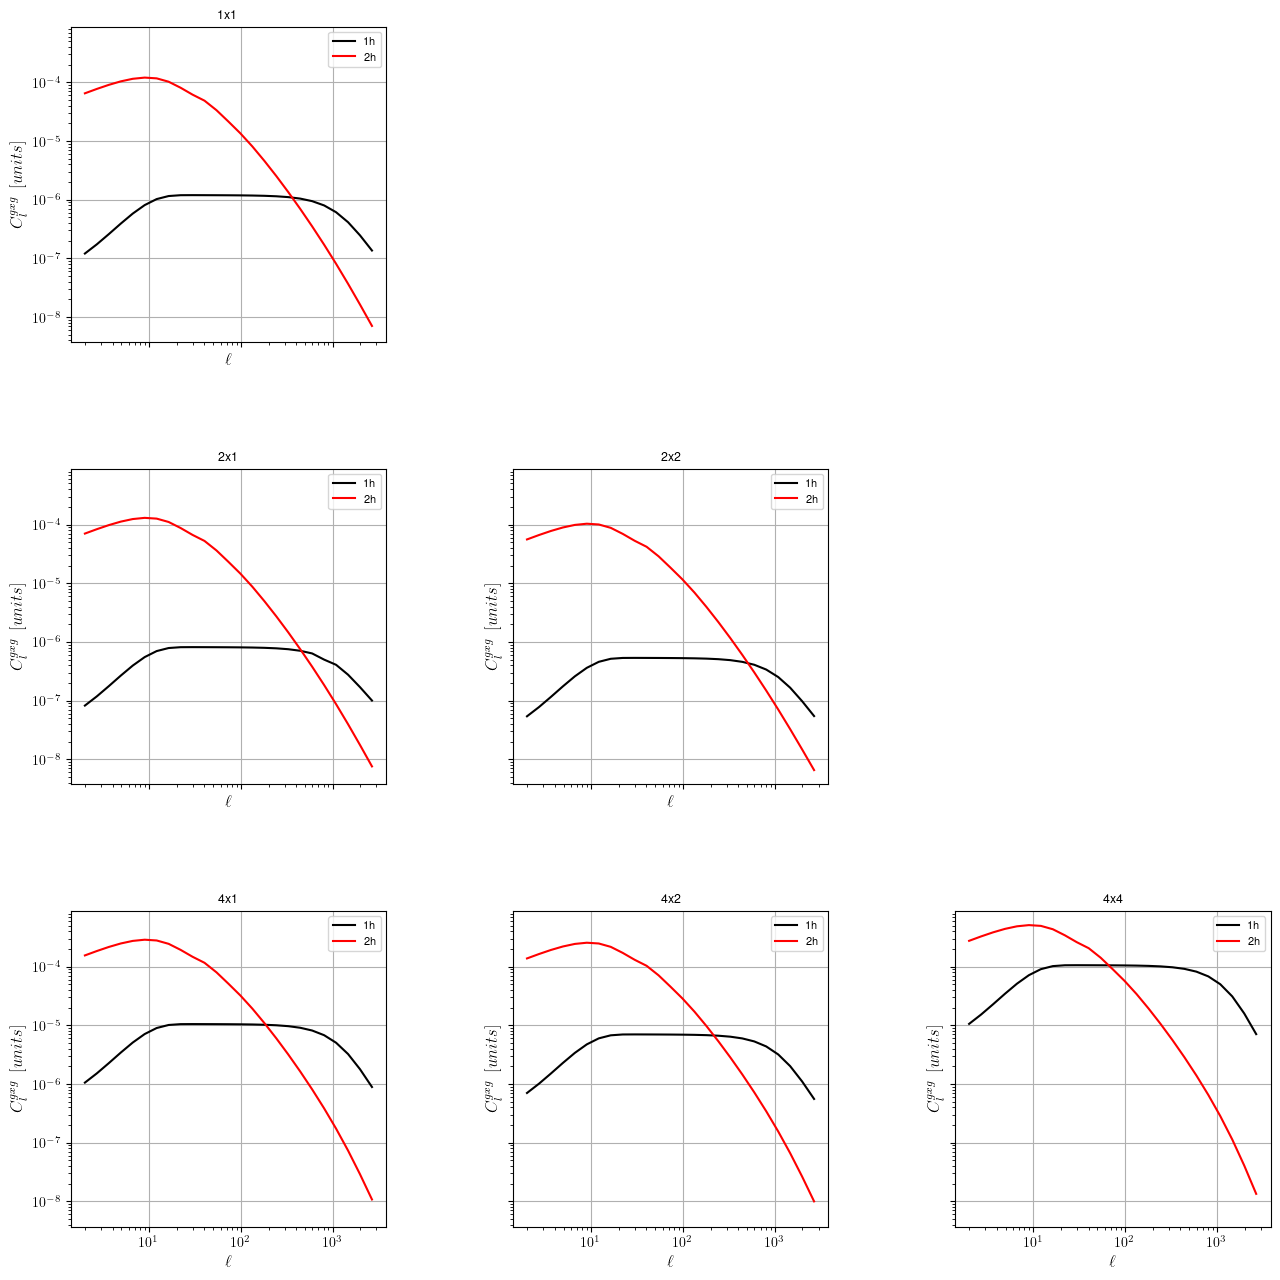

In [109]:

plot_dim = int(1/2*(-1 + np.sqrt(1 + 8*len(cl_galn_galn.keys()))))
fig, axes = plt.subplots(figsize=(15, 15), sharex=True, 
                         sharey=True, 
                         ncols=plot_dim, 
                         nrows=plot_dim,
                         )
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# x = np.linspace(0, 10, 100)
ik = 0
for i in range(plot_dim):
    for j in range(plot_dim):
        if i<j:
            axes[i, j].axis('off')
        else:
            kk = list(cl_galn_galn.keys())[ik]
            ik+=1
            # axes[i, j].plot(x, np.sin((i+j) *x))
            axes[i, j].set_title(kk,size=9)
            axes[i, j].set_xlabel(r"$\ell$",fontsize=12)
            axes[i, j].set_ylabel(r"$C_l^{gxg} \,\,\, [units]$",fontsize=12)

            axes[i, j].grid()
            #
            cl = cl_galn_galn[kk]
            fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

            axes[i, j].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',label=r'1h')
            axes[i, j].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',label=r'2h')
            axes[i, j].legend(loc=1,fontsize=8)

# Halo model galaxy-cmb lensing power spectra<a id = 'cl_gk'></a>

In [110]:
%%time
M = Class()
M.set(cosmo_params)
M.set({
# 'output' : 'gal_lens_1h,gal_lens_2h,galn_lens_1h,galn_lens_2h',
'output' : 'galn_lens_1h,galn_lens_2h',
'galaxy_samples_list_num' : 3, # the number of galaxy samples
'galaxy_samples_list' : '1,2,4', # the id string of each sample, can be any integer
'full_path_and_prefix_to_dndz_ngal':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/class_sz_auxiliary_files/WISC_bin3_ngal_example',
'full_path_to_dndz_gal':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/class_sz_auxiliary_files/WISC_bin3_ngal_example1.txt',
'galaxy_sample' : 'custom'
})
M.set({# class_sz parameters:

'mass function': 'T08M200c',
'concentration parameter' : 'D08',
'hm_consistency': 1,

'delta for galaxies' : '200c',
'delta for matter density' : '200c',
    
'x_out_truncated_nfw_profile' : 1,

# HOD parameters
'sigma_log10M_HOD' : 0.69,
'alpha_s_HOD' :  1.30,
'M1_prime_HOD' : 5.03e12, # Msun/h
'M_min_HOD' : 6.25e11, # Msun/h
# 'M0_HOD' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies' : 1.09,    
'f_cen_HOD' : 1., 
    
    
# HOD parameters
'sigma_log10M_HOD_ngal_0' : 0.69,
'alpha_s_HOD_ngal_0' :  1.30,
'M1_prime_HOD_ngal_0' : 5.03e12, # Msun/h
'M_min_HOD_ngal_0' : 6.25e11, # Msun/h
# 'M0_HOD_ngal_0' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_0' : 1.09,    
'f_cen_HOD_ngal_0' : 1., 
    
'sigma_log10M_HOD_ngal_1' : 0.79,
'alpha_s_HOD_ngal_1' :  1.30,
'M1_prime_HOD_ngal_1' : 5.43e12, # Msun/h
'M_min_HOD_ngal_1' : 6.15e11, # Msun/h
'M0_HOD_ngal_1' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_1' : 1.19,  
'f_cen_HOD_ngal_1' : 1.,    
    
'sigma_log10M_HOD_ngal_2' : 0.49,
'alpha_s_HOD_ngal_2' :  1.70,
'M1_prime_HOD_ngal_2' : 6.03e12, # Msun/h
'M_min_HOD_ngal_2' : 7.25e11, # Msun/h
'M0_HOD_ngal_2' : 0,  # Msun/h
'x_out_truncated_nfw_profile_satellite_galaxies_ngal_2' : 0.89,  
'f_cen_HOD_ngal_2' : 1.,

'M0 equal M_min (HOD)'  : 'yes',



'M_min' : 1e11,
'M_max' : 5e15,
'ndim_masses' : 100,
    
    
'z_min' : 1e-3,
'z_max' : 3.,
'ndim_redshifts' : 100,
    
    
'dlogell' : 0.3,
'ell_max' : 3000.0,
'ell_min' : 2.0,


    
# precisions params:
'non_linear' : 'halofit',
'k_min_for_pk_class_sz' :  0.001,
'k_max_for_pk_class_sz' :  60.0,
'k_per_decade_class_sz' :  50,
'P_k_max_h/Mpc' :  50.0,

    
'redshift_epsabs' : 1e-40,
'redshift_epsrel' : 0.0001,
'mass_epsabs' : 1e-40,
'mass_epsrel' : 0.0001    
    
        })
        
M.compute_class_szfast()
cl_galn_lens = M.cl_galn_lens()
cl_gal_lens = M.cl_kg()

CPU times: user 2.75 s, sys: 184 ms, total: 2.93 s
Wall time: 767 ms


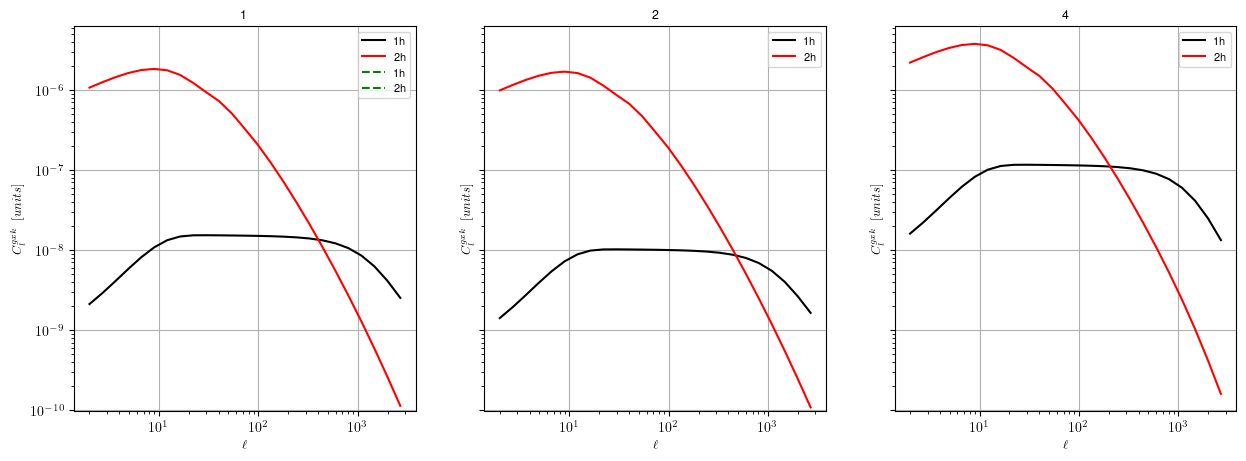

In [111]:
plot_dim = len(cl_galn_lens.keys())
fig, axes = plt.subplots(figsize=(15, 5), 
                         sharex=True, 
                         sharey=True, 
                         ncols=plot_dim
                         )
plt.subplots_adjust(#left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.4,
                    hspace=0.4)
# x = np.linspace(0, 10, 100)
ik = 0
for i in range(plot_dim):
    kk = list(cl_galn_lens.keys())[ik]
    ik+=1
    # axes[i, j].plot(x, np.sin((i+j) *x))
    axes[i].set_title(kk,size=9)
    axes[i].set_xlabel(r"$\ell$",fontsize=9)
    axes[i].set_ylabel(r"$C_l^{gxk} \,\,\, [units]$",fontsize=9)

    axes[i].grid()
    
    cl = cl_galn_lens[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    axes[i].loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',label=r'1h')
    axes[i].loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',label=r'2h')
    # axes[i].loglog(cl['ell'],np.asarray(cl['hf'])/fac,'k-',label=r'hf')
    if kk == '1':
        cl = cl_gal_lens
        fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

        axes[i].loglog(cl['ell'],np.asarray(cl['1h'])/fac,label=r'1h',ls='--',c='g')
        axes[i].loglog(cl['ell'],np.asarray(cl['2h'])/fac,label=r'2h',ls='--',c='g')        

    axes[i].legend(loc=1,fontsize=8)

# Combo Calculation<a id = 'combo'></a>

In [112]:
%%time
M = Class()
output_str = 'cib_cib_1h,cib_cib_2h'
output_str += ',lens_cib_1h,lens_cib_2h'
output_str += ',gal_gal_1h,gal_gal_2h'
output_str += ',gal_lens_1h,gal_lens_2h'
output_str += ',gallens_lens_1h,gallens_lens_2h'
output_str += ',gallens_gallens_1h,gallens_gallens_2h'
output_str += ',tSZ_gallens_1h,tSZ_gallens_2h'
output_str += ',gal_gallens_1h,gal_gallens_2h'
output_str += ',gal_cib_1h,gal_cib_2h'
output_str += ',gallens_cib_1h,gallens_cib_2h'
output_str += ',tSZ_1h,tSZ_2h'
output_str += ',lens_1h,lens_2h'
output_str += ',tSZ_gal_1h,tSZ_gal_2h'
output_str += ',tSZ_lens_1h,tSZ_lens_2h'
output_str += ',tSZ_cib_1h,tSZ_cib_2h'
M.set({'output':output_str})
M.set(cosmo_params)
M.set({

'mass function' : 'T08M200c',
'use_maniyar_cib_model':1,

'maniyar_cib_etamax' : 5.12572945e-01,

'maniyar_cib_zc' : 1.5,
'maniyar_cib_tau' : 8.25475287e-01,
'maniyar_cib_fsub' : 0.134*np.log(10.),
'Most efficient halo mass in Msun' : 5.34372069e+12,
'Size of of halo masses sourcing CIB emission' :  1.5583436676980493,
#for the Lsat tabulation:
'freq_min': 500,
'freq_max': 600,
'dlogfreq' : 0.3,

'concentration parameter':'B13', # this sets it to 5

'n_z_L_sat' :50,
'n_m_L_sat' :50,
'n_nu_L_sat':10,

'use_nc_1_for_all_halos_cib_HOD': 1,

'sub_halo_mass_function' : 'TW10',#'JvdB14',
'M_min_subhalo_in_Msun' : 1e5, # 1e5 see https://github.com/abhimaniyar/halomodel_cib_tsz_cibxtsz/blob/master/Cell_cib.py
'use_redshift_dependent_M_min': 0,
'M_min' : 1e10,
'M_max' : 1e15,
'z_min' : 0.05,
'z_max' : 10.,
'ell_min': 2.,
'ell_max':8000,
'dlogell':0.2,


'ndim_redshifts': 50,
'ndim_masses':100,

'has_cib_flux_cut': 0,
'hm_consistency':1,

    
    
'use_fft_for_profiles_transform' : 1,
    
    
'damping_1h_term' : 0,

})

M.set({
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '545',
      })
M.compute_class_szfast()

CPU times: user 3min 53s, sys: 516 ms, total: 3min 54s
Wall time: 26.2 s


In [113]:
specs_dict = {
'cib x cib' : M.cl_cib_cib()['545x545'],
'cib x kc' : M.cl_lens_cib()['545'],
'g x cib' : M.cl_gal_cib()['545'],
'g x g' : M.cl_gg(),
'g x kc' : M.cl_kg(),
'kg x kg' : M.cl_kg_kg(),
'kg x g' : M.cl_ggamma(),
'y x y' : M.cl_sz(),
'g x y' : M.cl_yg(),
'y x kc' : M.cl_y_kcmb(),
'kc x kc' : M.cl_kk(),
'cib x y' : M.cl_tSZ_cib()['545'],
'kg x kc' : M.cl_kg_k(),
'kg x y' : M.cl_ykg(),
'kg x cib' : M.cl_kg_cib()['545'],
}

In [114]:
plot_keys = ['kc x kc',
             'y x kc',
             'y x y',
             'cib x kc',
             'cib x y',
             'cib x cib',
             'g x kc',
             'g x y',
             'g x cib',
             'g x g',
             'kg x kc',
             'kg x y',
             'kg x cib',
             'kg x g',
             'kg x kg']

plot_keys_latex = [r'$\kappa_\mathrm{cmb}$ x $\kappa_\mathrm{cmb}$',r'$y$ x $\kappa_{cmb}$',
             r'$y$ x $y$',r'$\mathrm{CIB}$ x $\kappa_\mathrm{cmb}$',
             r'$\mathrm{CIB}$ x $y$',r'$\mathrm{CIB}$ x $\mathrm{CIB}$',
             r'$\delta_g$ x $\kappa_\mathrm{cmb}$',r'$\delta_g$ x $y$',r'$\delta_g$ x $\mathrm{CIB}$',r'$\delta_g$ x $\delta_g$',r'$\kappa_{g}$ x $\kappa_\mathrm{cmb}$',r'kg x $y$',r'$\kappa_{g}$ x $\mathrm{CIB}$',
             r'$\kappa_{g}$ x $\delta_g$',r'$\kappa_{g}$ x $\kappa_{g}$']

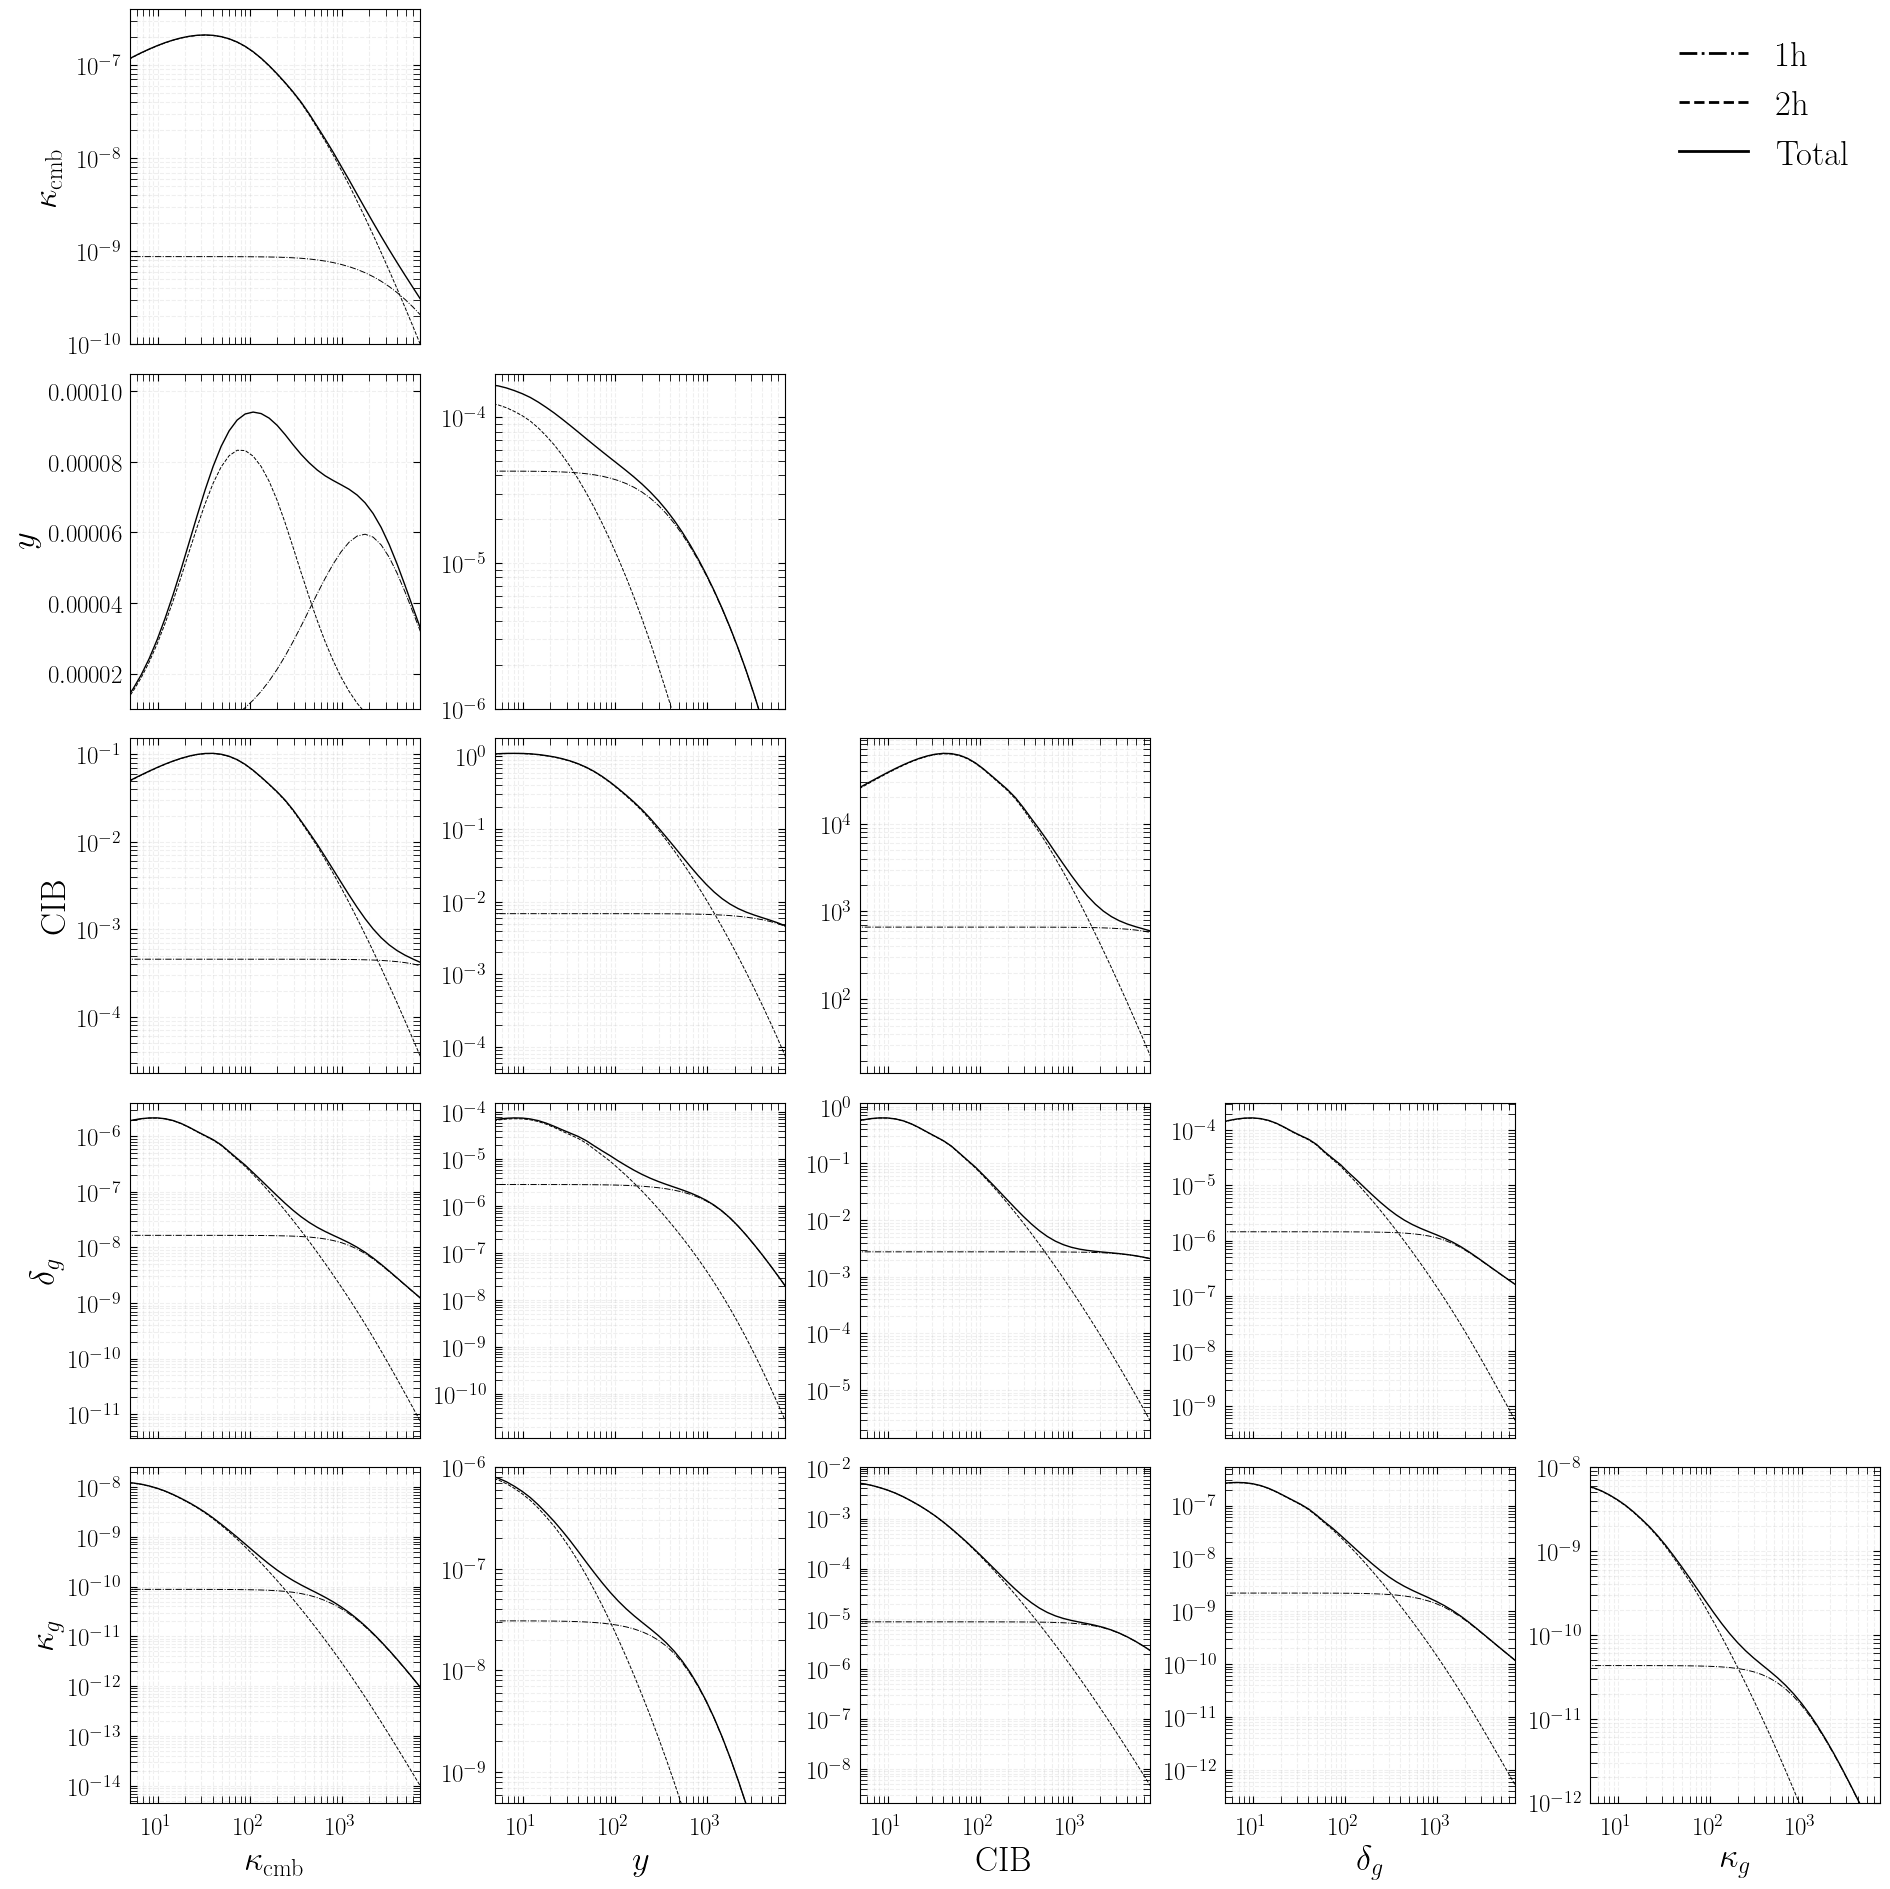

In [115]:
from matplotlib.lines import Line2D
# cl_cib_cib = M.cl_cib_cib()
# freq = ['100', '143', '217', '353', '545', '857']
# # freq = ['545']
# # nu1, nu2 = 4, 4
# # plot_Cell(ell, cl1h_cib, cl2h_cib, nu1, nu2, freq, 'CIB')
# two_halo = cl2h_cib
# one_halo = cl1h_cib
# faccib = 1.

plot_dim = int(1/2*(-1 + np.sqrt(1 + 8*len(plot_keys))))
# plot_dim = len(freq)
fig, axes = plt.subplots(figsize=(19, 19),
                         sharex=True,
                         #sharey=True,
                         ncols=plot_dim,
                         nrows=plot_dim)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.0,
                    hspace=0.0)
ik = 0
for i in range(plot_dim):
    for j in range(plot_dim):
        if i==0 and j==(plot_dim-1):
            ax = axes[i, j]
            custom_lines = [Line2D([0], [0], color='k', lw=2,ls='-.'),
                            Line2D([0], [0], color='k', lw=2,ls='--'),
                            Line2D([0], [0], color='k', lw=2,ls='-')]
            ax.legend(custom_lines, [r'$\mathrm{1h}$', r'$\mathrm{2h}$', r'$\mathrm{Total}$'],
                      fontsize=25,frameon=False)
            # ax.legend()
            ax.axis('off')
        elif i<j:
            axes[i, j].axis('off')
        else:
            ax = axes[i, j]
            clsp = specs_dict[plot_keys[ik]]
            if j==0:
                # ax.set_ylabel(r'$\mathrm{C_l}\: [\mathrm{Jy}^2\: \mathrm{sr}^{-1}]$', fontsize=12)
                ax.set_ylabel(plot_keys_latex[ik].split(' x ')[0], fontsize=25)
            if i==(plot_dim-1):
                ax.set_xlabel(plot_keys_latex[ik].split(' x ')[1], fontsize=25)
            
            ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
            ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
            ax.xaxis.set_ticks_position('both')
            ax.yaxis.set_ticks_position('both')
            plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=18)
            plt.setp(ax.get_xticklabels(), fontsize=18)
            ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlim(5,7000)
            if clsp:
                # print(plot_keys[ik],clsp)
                l = np.asarray(clsp['ell'])
                # ax.plot(l[l>5.],np.asarray(clsp['1h']/l_to_dl(l))[l>5.],ls='-.',c='k',label='class_sz 1h ')
                ax.plot(l,np.asarray(clsp['1h']/l_to_dl(l)),ls='-.',c='k',label='class_sz 1h',lw=0.7)
                ax.plot(l,clsp['2h']/l_to_dl(l),ls='--',c='k',label='class_sz 2h',lw=0.7)
                ax.plot(l,clsp['2h']/l_to_dl(l)+np.asarray(clsp['1h']/l_to_dl(l)),ls='-',c='k',label='class_sz Total',lw=1)

            # if freqs=='100' and freqsp=='100':
                # ax.set_ylim(5e-3,5)
            if plot_keys[ik] == 'kc x kc':
                ax.set_ylim(1e-10,4e-7)
            if plot_keys[ik] == 'y x kc':
                ax.set_ylim(1e-5,10.5e-5)
                ax.set_yscale("linear")
            if plot_keys[ik] == 'y x y':
                ax.set_ylim(1e-6,2e-4)
            if plot_keys[ik] == 'kg x kg':
                ax.set_ylim(1e-12,1e-8)
            if plot_keys[ik] == 'kg x y':
                ax.set_ylim(5e-10,1e-6)
            ik+=1
 
# fig.suptitle('CLASS_SZ COMBO PLOT',fontsize=20)
fig.tight_layout()

# Custom Tracer<a id = 'custom'></a>

In [116]:
def custom1_ux(x,m,z,classy_sz,*params):
    # m is m_delta and delta is the definition passed for custom1 profile
    # x is r/r_delta

    # delta is collected as:
    delta_def = classy_sz.delta_def_custom1()
    delta = classy_sz.get_delta_from_delta_def_at_z(delta_def,z)

    # to get r_delta:
    r_delta = classy_sz.get_r_delta_of_m_delta_at_z(delta,m,z)

    # to get c_delta:
    c_delta = classy_sz.get_c_delta_at_m_and_z(m,z,delta_def)

    # to get x_out:
    x_out = classy_sz.x_out_custom1()


    # example: nfw profile/cmb lensing
    rs = r_delta/c_delta
    xs = x*r_delta/rs
    prof = xs**-1.*(1.+ xs)**-2.
    norm = m*c_delta**3/(np.log(1.+x_out*c_delta)-x_out*c_delta/(1.+x_out*c_delta))

    return norm*prof

def custom1_W(z,classy_sz,*params):
    # e.g., we want (chi_star - chi)/chi
    chi_star = classy_sz.chi_star()
    chi = classy_sz.get_chi(z)
    H = classy_sz.Hubble(z)
    Rho_crit_0 = classy_sz.Rho_crit_0()

    h = classy_sz.h()
    H0 = classy_sz.Hubble(0)


    # example: cmb lensing
    if z==0.:
        w = 1e-100
    else:
        w = 3./2.*(H0/h)**2/Rho_crit_0*(chi/(1.+z))**-1.*(chi_star-chi)/chi_star # 

    return w

In [117]:
%%time

M = Class()

M.set(cosmo_params)
M.set({

    
'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',

'hm_consistency' : 1,
'x_outSZ': 4.,
# 'truncate_gas_pressure_wrt_rvir':0,
    
    
'output': 'tSZ_1h,tSZ_2h,tSZ_custom1_1h,tSZ_custom1_2h,tSZ_lens_1h,tSZ_lens_2h,custom1_custom1_1h,custom1_lens_1h,custom1_lens_2h,custom1_custom1_2h,lens_lens_1h,lens_lens_2h',

'pressure profile':'Custom. GNFW',
    
"P0GNFW": 8.130,
"c500": 1.156,
"gammaGNFW": 0.3292,
"alphaGNFW": 1.0620,
"betaGNFW":5.4807,

"ell_min" : 2,
"ell_max" : 8000,
'dell': 0,
'dlogell': 0.2,
    
'M_min' : 1.0e10, 
'M_max' : 5e15,
    
'z_min' : 0.,
'z_max' : 4.0,
'n_m_pressure_profile' :50, # default: 100, decrease for faster
'n_z_pressure_profile' :50, # default: 100, decrease for faster


    
    
'hm_consistency' : 1,
    

'use_fft_for_profiles_transform' : 1,

'N_samp_fftw' : 8192,
'x_min_gas_pressure_fftw' : 1e-4,
'x_max_gas_pressure_fftw' : 1e3,
    

# custom parameters
'x_min_custom1_fftw' : 1e-5,
'x_max_custom1_fftw' : 1e12,   
'n_m_custom1_profile': 30,
'n_z_custom1_profile': 30,
'delta_for_custom1' : '200c',
'x_out_custom1' : 1.,
'array_custom1_redshift_kernel_n_z' : 200,
    
# 'ndim_masses' : 500, # now muted/set by k's in cosmopower emulator.
'ndim_redshifts' :200,

    
'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0001,    

    
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0001,
    
    
})
M.compute_class_szfast()
# M.compute()

CPU times: user 30.2 s, sys: 393 ms, total: 30.6 s
Wall time: 22.4 s


In [118]:
l = np.asarray(M.cl_sz()['ell'])
cl_yy_1h = np.asarray(M.cl_sz()['1h'])
cl_yy_2h = np.asarray(M.cl_sz()['2h'])

In [119]:
cl_c1k_1h = np.asarray(M.cl_c1_lens()['1h'])
cl_c1k_2h = np.asarray(M.cl_c1_lens()['2h'])
cl_c1c1_1h = np.asarray(M.cl_c1c1()['1h'])
cl_c1c1_2h = np.asarray(M.cl_c1c1()['2h'])
cl_kk_1h = np.asarray(M.cl_kk()['1h'])
cl_kk_2h = np.asarray(M.cl_kk()['2h'])

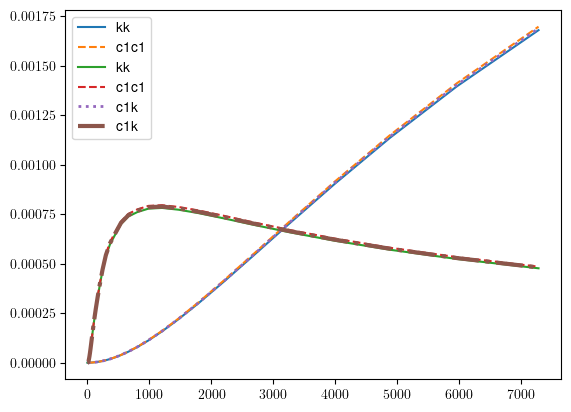

In [120]:
plt.plot(l,cl_kk_1h,label='kk')
plt.plot(l,cl_c1c1_1h,label='c1c1',ls='--')
plt.plot(l,cl_kk_2h,label='kk')
plt.plot(l,cl_c1c1_2h,label='c1c1',ls='--')
plt.plot(l,cl_c1k_1h,label='c1k',ls=':',lw=2.)
plt.plot(l,cl_c1k_2h,label='c1k',ls='-.',lw=3)
# plt.loglog()
plt.legend()